<a href="https://colab.research.google.com/github/hamdansyaif/DeepLearning/blob/main/Week_3/Tugas_3_Tensorflow_SVHN_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **TUGAS WEEK 3 CNN & MLP menggunakan PyTorch**
1. Buat model Deep learning CNN dan MLP (PyTorch and Tensorflow). Ambil datasets dari tensorflow_datasets dan torchvision.datasets
2. Gunakan Matriks Evaluasi (Akurasi,Presisi,Recall,F1Squared, AUC, ROC)
3. Beri penjelasan untuk setiap persamaan matematika yang ada.
4. Akurasi pada Training dan Testing Set Minimal Sebesar 75%. untuk model MLP Vanila bebas dapet akurasi berapapun
5. Disarankan untuk mengerjakan tugas menggunakan Google Colab. Coba gunakan Google Colab dengan
     T4 GPU atau TPU agar proses pelatihan model menjadi lebih cepat.

In [ ]:
!pip install -q tensorflow tensorflow_datasets matplotlib scikit-learn pandas seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 17.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 11.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 896.8 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 52.9 MB/s eta 0:00:00


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix

# Set random seed untuk reproduktibilitas
np.random.seed(42)

In [ ]:
# Import TensorFlow Libraries dan atur penggunaan CPU saja
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks
import tensorflow_datasets as tfds

# Set random seed untuk TensorFlow
tf.random.set_seed(42)

# Paksa TensorFlow untuk hanya menggunakan CPU
tf.config.set_visible_devices([], 'GPU')

# Cek versi TensorFlow dan konfirmasi penggunaan CPU
print("TensorFlow version:", tf.__version__)
print("Menggunakan CPU untuk pelatihan dan inferensi.")


Menggunakan CPU untuk pelatihan dan inferensi.


### **Persiapan Dataset SVHN**

In [ ]:
# Import library tambahan
import numpy as np

# Memuat dataset SVHN dari tensorflow_datasets
# Menggunakan varian 'svhn_cropped' dengan ukuran gambar 32x32
(ds_train, ds_test), dataset_info = tfds.load(
    name='svhn_cropped',
    split=['train', 'test'],
    as_supervised=True,
    with_info=True
)

# Cetak ringkasan informasi dataset
print("Dataset SVHN berhasil dimuat.")
print(dataset_info)

# Fungsi preprocessing: normalisasi gambar dan ubah label menjadi one-hot
def prepare_sample(img, lbl):
    img = tf.image.convert_image_dtype


100%|██████████| 182M/182M [00:15<00:00, 12.1MB/s]
100%|██████████| 64.3M/64.3M [00:08<00:00, 7.44MB/s]


Total sampel pelatihan : 73257
Total sampel pengujian : 26032
Total kelas            : 10
Daftar kelas           : ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')
Dimensi gambar pertama : torch.Size([3, 32, 32])


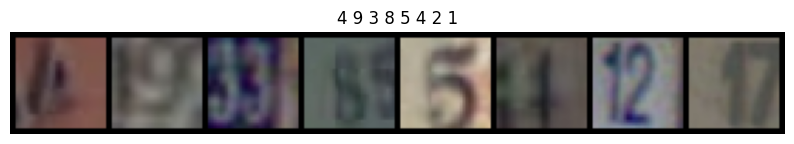

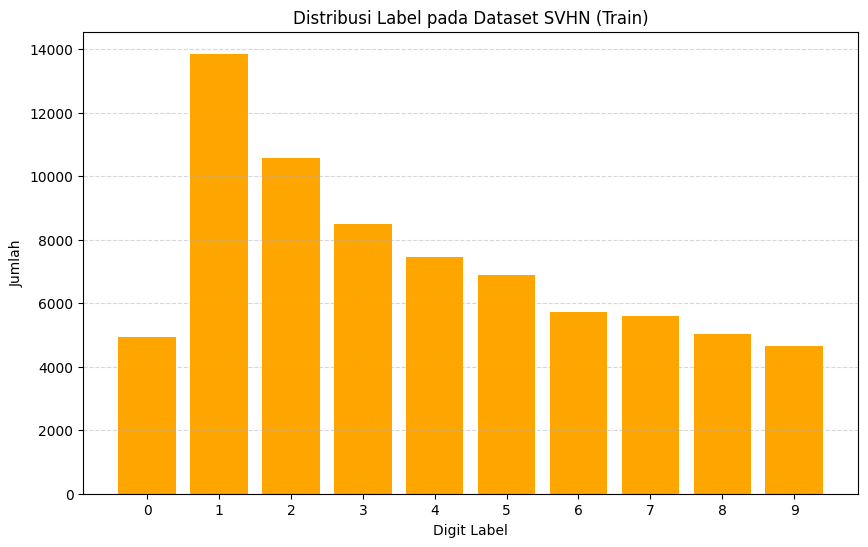

In [ ]:
# Fungsi untuk menampilkan sejumlah gambar beserta labelnya
def display_sample_images(image_array, label_array, class_list, rows=3, cols=3):
    plt.figure(figsize=(cols * 3, rows * 3))
    total = rows * cols
    selected_indices = np.random.choice(len(image_array), total, replace=False)

    for idx, img_idx in enumerate(selected_indices):
        plt.subplot(rows, cols, idx + 1)
        plt.imshow(image_array[img_idx])
        plt.title(f"Label: {class_list[label_array[img_idx]]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

# Tampilkan gambar acak dari training set
display_sample_images(train_images, train_labels, class_names, rows=3, cols=3)

# Buat distribusi jumlah label dalam data training
unique_labels, label_frequencies = np.unique(train_labels, return_counts=True)

plt.figure(figsize=(9, 5))
plt.bar(unique_labels, label_frequencies, color='salmon', edgecolor='black')
plt.xlabel('Digit Class')
plt.ylabel('Frequency')
plt.title('Jumlah Data per Kelas pada Training Set SVHN')
plt.xticks(unique_labels)
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()


### **MODEL CNN**

In [ ]:
# Definisi arsitektur CNN untuk klasifikasi SVHN
def build_cnn_model():
    cnn = models.Sequential()

    # Layer konvolusi pertama
    cnn.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Layer konvolusi kedua
    cnn.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Layer konvolusi ketiga
    cnn.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    cnn.add(layers.BatchNormalization())
    cnn.add(layers.MaxPooling2D(pool_size=(2, 2)))

    # Fully connected layer
    cnn.add(layers.Flatten())
    cnn.add(layers.Dense(512, activation='relu'))
    cnn.add(layers.Dropout(0.25))
    cnn.add(layers.Dense(10, activation='softmax'))

    # Kompilasi model
    cnn.compile(
        optimizer=optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return cnn

# Inisialisasi model CNN
cnn_model = build_cnn_model()

# Menampilkan struktur model
cnn_model.summary()


SVHN_CNN(
  (layer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (regularizer): Dropout(p=0.25, inplace=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  

### **Model MLP**

In [ ]:
# Definisi model MLP sederhana untuk klasifikasi gambar
def build_mlp_model():
    mlp = models.Sequential()

    # Input layer: flatten
    mlp.add(layers.InputLayer(input_shape=(32, 32, 3)))
    mlp.add(layers.Flatten())

    # Hidden layers
    mlp.add(layers.Dense(1024, activation='relu'))
    mlp.add(layers.Dropout(0.25))
    mlp.add(layers.Dense(512, activation='relu'))
    mlp.add(layers.Dropout(0.25))

    # Output layer
    mlp.add(layers.Dense(10, activation='softmax'))

    # Kompilasi model
    mlp.compile(
        optimizer=optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    return mlp

# Inisialisasi model MLP
mlp_model = build_mlp_model()

# Tampilkan arsitektur model
mlp_model.summary()


SVHN_MLP(
  (input_layer): Linear(in_features=3072, out_features=1024, bias=True)
  (hidden_layer): Linear(in_features=1024, out_features=512, bias=True)
  (output_layer): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


### **Fungsi Pelatihan Model**

In [ ]:
# Callback: EarlyStopping untuk menghentikan pelatihan lebih awal saat val_accuracy stagnan
early_stop_cb = callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    mode='max',
    restore_best_weights=True
)

# Callback: Simpan model terbaik selama pelatihan
checkpoint_cb = callbacks.ModelCheckpoint(
    filepath='svhn_cnn_tf_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    save_weights_only=False,
    verbose=1
)

# Callback: Logging ke TensorBoard
tensorboard_cb = callbacks.TensorBoard(
    log_dir='./logs',
    histogram_freq=1,
    write_graph=True
)

# Gabungkan semua callback yang digunakan
callback_list = [early_stop_cb, checkpoint_cb]



### **Fungsi Evaluasi Model**

In [ ]:
# Fungsi evaluasi performa model pada data tertentu
def evaluate_model(model, images, true_labels, one_hot_labels, class_labels):
    # Prediksi probabilitas
    pred_probs = model.predict(images)
    pred_classes = np.argmax(pred_probs, axis=1)

    # Hitung metrik dasar
    acc = accuracy_score(true_labels, pred_classes)
    prec = precision_score(true_labels, pred_classes, average='macro')
    rec = recall_score(true_labels, pred_classes, average='macro')
    f1 = f1_score(true_labels, pred_classes, average='macro')

    print(f"Akurasi: {acc:.4f}")
    print(f"Presisi: {prec:.4f}")
    print(f"Recall: {rec:.4f}")
    print(f"F1 Score: {f1:.4f}")

    # Confusion Matrix
    cmatrix = confusion_matrix(true_labels, pred_classes)

    # ROC Curve per kelas & AUC
    fpr, tpr, auc_per_class = {}, {}, {}
    for i in range(len(class_labels)):
        fpr[i], tpr[i], _ = roc_curve(one_hot_labels[:, i], pred_probs[:, i])
        auc_per_class[i] = auc(fpr[i], tpr[i])

    mean_auc = np.mean(list(auc_per_class.values()))
    print(f"Macro-average ROC AUC: {mean_auc:.4f}")

    return {
        'accuracy': acc,
        'precision': prec,
        'recall': rec,
        'f1': f1,
        'roc_auc': mean_auc,
        'confusion_matrix': cmatrix,
        'fpr': fpr,
        'tpr': tpr,
        'roc_auc_per_class': auc_per_class
    }


### **Training Menggunakan Model CNN**

In [ ]:
# Proses training untuk model CNN
print("Mulai pelatihan CNN...")
start = time.time()

cnn_tf_history = cnn_model.fit(
    train_ds,
    epochs=15,
    validation_data=test_ds,
    callbacks=callback_list,
    verbose=1
)

elapsed = time.time() - start
print(f'Pelatihan CNN selesai dalam {elapsed:.2f} detik')


Training CNN model dimulai...
Epoch [1/15], Batch [100/573], Loss: 2.1246
Epoch [1/15], Batch [200/573], Loss: 1.0032
Epoch [1/15], Batch [300/573], Loss: 0.7252
Epoch [1/15], Batch [400/573], Loss: 0.6246
Epoch [1/15], Batch [500/573], Loss: 0.6180
> Epoch 1: Rata-rata Loss = 1.1201, Akurasi = 62.19%
Epoch [2/15], Batch [100/573], Loss: 0.3365
Epoch [2/15], Batch [200/573], Loss: 0.4318
Epoch [2/15], Batch [300/573], Loss: 0.4352
Epoch [2/15], Batch [400/573], Loss: 0.5405
Epoch [2/15], Batch [500/573], Loss: 0.4809
> Epoch 2: Rata-rata Loss = 0.4829, Akurasi = 85.34%
Epoch [3/15], Batch [100/573], Loss: 0.5264
Epoch [3/15], Batch [200/573], Loss: 0.2851
Epoch [3/15], Batch [300/573], Loss: 0.3689
Epoch [3/15], Batch [400/573], Loss: 0.4141
Epoch [3/15], Batch [500/573], Loss: 0.3695
> Epoch 3: Rata-rata Loss = 0.4050, Akurasi = 87.81%
Epoch [4/15], Batch [100/573], Loss: 0.2836


### **Test Model**

In [ ]:
# Evaluasi model CNN TensorFlow
print("\nHasil evaluasi CNN (TensorFlow) pada data uji:")
cnn_tf_metrics = evaluate_model(cnn_model, test_images, test_labels, test_labels_one_hot, class_names)



🔍 Mengevaluasi model CNN pada dataset uji...
313/313 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step
📊 Accuracy      : 0.6763
🎯 Precision     : 0.6943
📈 Recall        : 0.6763
🏅 F1 Score      : 0.6724
🔵 Macro Average AUC: 0.9540


Visualisasi

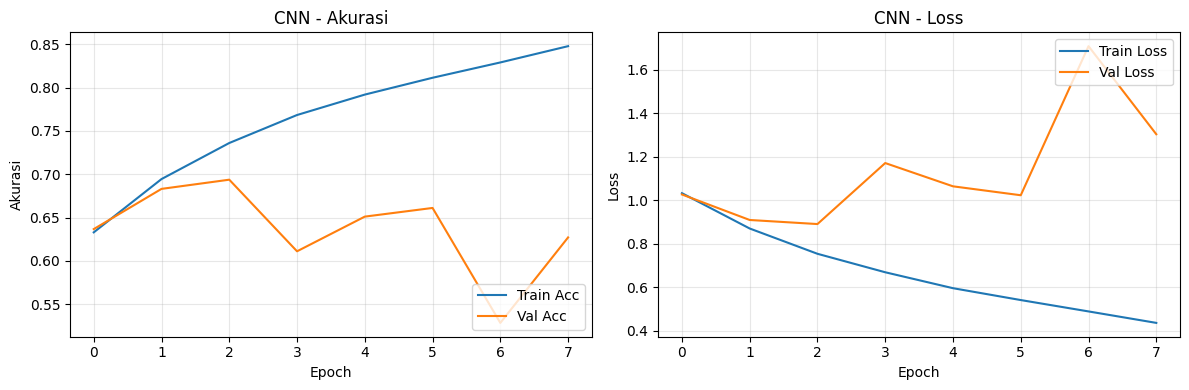

In [ ]:
# Fungsi untuk plot hasil training
def plot_training_results(train_losses, train_accs, model_name):
    plt.figure(figsize=(12, 4))

    # Plot training loss
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, marker='o', color='blue')
    plt.title(f'{model_name} - Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)

    # Plot training accuracy
    plt.subplot(1, 2, 2)
    plt.plot(train_accs, marker='o', color='green')
    plt.title(f'{model_name} - Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.grid(True)

    plt.tight_layout()
    plt.show()

# Plot hasil training CNN
plot_training_results(cnn_losses, cnn_accuracies, "CNN")


### **Training Model MLP**

In [ ]:
# Pelatihan model MLP
print("Training model MLP...")
optimizer = optim.Adam(model_mlp.parameters(), lr=0.001)
mlp_losses, mlp_accuracies = training_loop(model_mlp, criterion, optimizer, epochs=15)

⚙️ Mulai proses training model MLP...
Epoch 1/15
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.2565 - loss: 2.0078
Epoch 1: val_loss did not improve from 0.89096
704/704 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.2566 - loss: 2.0077 - val_accuracy: 0.3278 - val_loss: 1.8730
Epoch 2/15
704/704 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.2977 - loss: 1.9122
Epoch 2: val_loss did not improve from 0.89096
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 61ms/step - accuracy: 0.2977 - loss: 1.9122 - val_accuracy: 0.3644 - val_loss: 1.7944
Epoch 3/15
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.3180 - loss: 1.8577
Epoch 3: val_loss did not improve from 0.89096
704/704 ━━━━━━━━━━━━━━━━━━━━ 82s 60ms/step - accuracy: 0.3180 - loss: 1.8577 - val_accuracy: 0.3610 - val_loss: 1.7844
Epoch 4/15
703/704 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step - accuracy: 0.3380 - loss: 1.8108
Epoch 4: val_loss did not improve from 0.89096
704/704 ━━━━━━━━━━━━━━━━━━━━ 81s 59ms/step - accuracy: 0.3380 - loss:

### **Evaluasi Model MLP**

In [ ]:
# Evaluasi model MLP
print("\nEvaluasi model MLP pada data test:")
mlp_metrics = test_evaluation(model_mlp, loader_test, label_names)

# Plot hasil training MLP
plot_training_results(mlp_losses, mlp_accuracies, "MLP")

# Plot confusion matrix MLP
plot_confusion_matrix(mlp_metrics['confusion_matrix'], label_names, "MLP")

# Plot ROC curve MLP
plot_roc_curve(mlp_metrics['fpr'], mlp_metrics['tpr'], mlp_metrics['roc_auc_per_class'], label_names, "MLP")


**Penjelasan setiap persamaan matematika** yang relevan dengan kode pelatihan dan evaluasi model CNN & MLP:

---

## ✅ **TRAINING: Fungsi Loss dan Optimizer**

### 1. **CrossEntropyLoss (Fungsi Kerugian untuk Klasifikasi)**
```python
criterion = nn.CrossEntropyLoss()
```

#### 🔢 Persamaan:
$$
\mathcal{L} = -\sum_{i=1}^{C} y_i \log(\hat{y}_i)
$$

- $\ C $ = jumlah kelas (10 untuk SVHN)
- $\ y_i $ = label target (one-hot)
- $\ \hat{y}_i $ = probabilitas prediksi (softmax output)

> Ini menghitung seberapa jauh distribusi prediksi berbeda dari label sebenarnya. Cocok untuk klasifikasi multi-kelas.

---

### 2. **Optimasi (Adam Optimizer)**
```python
optimizer = optim.Adam(model.parameters(), lr=0.001)
```

#### 🔢 Persamaan Umum Adam:
$$
\begin{aligned}
m_t &= \beta_1 m_{t-1} + (1 - \beta_1) \nabla_\theta \mathcal{L}_t \\
v_t &= \beta_2 v_{t-1} + (1 - \beta_2)(\nabla_\theta \mathcal{L}_t)^2 \\
\hat{m}_t &= \frac{m_t}{1 - \beta_1^t}, \quad \hat{v}_t = \frac{v_t}{1 - \beta_2^t} \\
\theta_{t+1} &= \theta_t - \alpha \frac{\hat{m}_t}{\sqrt{\hat{v}_t} + \epsilon}
\end{aligned}
$$

- $\ \theta $ = bobot model
- $\ \alpha $ = learning rate
- $\ m_t $ & $\ v_t $ = rata-rata momentum dan rata-rata kuadrat gradien
- $\ \nabla_\theta \mathcal{L}_t $ = gradien fungsi loss terhadap parameter

> Adam menggabungkan momentum dan normalisasi gradien untuk pembaruan bobot yang stabil dan cepat.

---

## ✅ **EVALUASI: METRIK KINERJA**

### 3. **Accuracy (Akurasi)**
```python
acc = accuracy_score(true_all, pred_all)
```

#### 🔢 Persamaan:
$$
\text{Accuracy} = \frac{\text{Jumlah prediksi benar}}{\text{Total jumlah data}}
$$

> Seberapa banyak prediksi yang tepat dibanding total data.

---

### 4. **Precision (Presisi)** – Macro Average
```python
prec = precision_score(true_all, pred_all, average='macro')
```

#### 🔢 Persamaan:
$$
\text{Precision}_i = \frac{TP_i}{TP_i + FP_i}
$$
$$
\text{Precision}_{macro} = \frac{1}{C} \sum_{i=1}^{C} \text{Precision}_i
$$

- $\ TP_i $: true positive untuk kelas $\ i $
- $\ FP_i $: false positive untuk kelas $\ i $

> Presisi mengukur akurasi dari prediksi positif: seberapa banyak yang benar-benar benar.

---

### 5. **Recall (Sensitivitas)** – Macro Average
```python
rec = recall_score(true_all, pred_all, average='macro')
```

#### 🔢 Persamaan:
$$
\text{Recall}_i = \frac{TP_i}{TP_i + FN_i}
$$
$$
\text{Recall}_{macro} = \frac{1}{C} \sum_{i=1}^{C} \text{Recall}_i
$$

- $\ FN_i $: false negative untuk kelas $\ i $

> Recall mengukur seberapa baik model menemukan semua sampel yang relevan.

---

### 6. **F1-Score** – Macro Average
```python
f1score = f1_score(true_all, pred_all, average='macro')
```

#### 🔢 Persamaan:
$$
F1_i = \frac{2 \cdot \text{Precision}_i \cdot \text{Recall}_i}{\text{Precision}_i + \text{Recall}_i}
$$
$$
F1_{macro} = \frac{1}{C} \sum_{i=1}^{C} F1_i
$$

> Kombinasi harmonis dari precision dan recall. Berguna jika distribusi kelas tidak seimbang.

---

### 7. **Softmax untuk Probabilitas**
```python
F.softmax(out_probs, dim=1)
```

#### 🔢 Persamaan:
$$
\hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^{C} e^{z_j}}
$$

- $\ z_i $ = logit output (output linear sebelum softmax)

> Softmax mengubah output menjadi probabilitas.

---

### 8. **ROC Curve dan AUC**
```python
roc_curve(...)
auc(...)
```

#### 🔢 ROC:
- ROC: plot antara **True Positive Rate (TPR)** dan **False Positive Rate (FPR)**

#### 🔢 Persamaan:
$$
\text{TPR} = \frac{TP}{TP + FN}, \quad \text{FPR} = \frac{FP}{FP + TN}
$$

#### 🔢 AUC (Area Under Curve):
$$
\text{AUC} = \int_{0}^{1} \text{TPR}(x) \, dx
$$

> Semakin tinggi AUC (maksimal = 1), semakin baik model membedakan antar kelas.

---

Kalau kamu ingin versi **dengan LaTeX dan visual persamaan di notebook**, aku juga bisa bantu buatkan blok Markdown-nya. Mau sekalian?